# Volatility forecasting (GARCH & ARCH)

> In this example, we'll forecast the volatility of the S&P 500 and several publicly traded companies using GARCH and ARCH models

::: {.callout-warning collapse="true"}

## Prerequesites

This tutorial assumes basic familiarity with StatsForecast. For a minimal example visit the [Quick Start](../getting-started/1_Getting_Started_short)
:::

## Introduction 

The Generalized Autoregressive Conditional Heteroskedasticity (GARCH) model is used for time series that exhibit non-constant volatility over time. Here volatility refers to the conditional standard deviation. The GARCH(p,q) model is given by 

\begin{equation}
y_t = v_t \sigma_t 
\end{equation}

where $v_t$ is independent and identically distributed with zero mean and unit variance, and $\sigma_t$ evolves according to 

\begin{equation}
\sigma_t^2 = w + \sum_{i=1}^p \alpha_i y^2_{t-i} + \sum_{j=1}^q \beta_j \sigma_{t-j}^2
\end{equation}

The coefficients in the equation above must satisfy the following conditions: 

1. $w>0$, $\alpha_i \geq 0$ for all $i$, and $\beta_j \geq 0$ for all $j$ 
2. $\sum_{k=1}^{max(p,q)} \alpha_k + \beta_k < 1$. Here it is assumed that $\alpha_i=0$ for $i>p$ and $\beta_j=0$ for $j>q$. 

A particular case of the GARCH model is the ARCH model, in which $q=0$. Both models are commonly used in finance to model the volatility of stock prices, exchange rates, interest rates, and other financial instruments. They're also used in risk management to estimate the probability of large variations in the price of financial assets. 

By the end of this tutorial, you'll have a good understanding of how to implement a GARCH or an ARCH model in [StatsForecast](../../index) and how they can be used to analyze and predict financial time series data. 

**Outline:**

1. Install libraries 
2. Load and explore the data
3. Train models 
4. Perform time series cross-validation 
5. Evaluate results 
6. Forecast volatility 

::: {.callout-tip}
You can use Colab to run this Notebook interactively <a href="https://colab.research.google.com/github/Nixtla/statsforecast/blob/main/nbs/docs/tutorials/GARCH_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
::: 

## Install libraries 

We assume that you have StatsForecast already installed. If not, check this guide for instructions on [how to install StatsForecast](../getting-started/0_Installation)

Install the necessary packages using `pip install statsforecast`

In [ ]:
%%capture
pip install statsforecast -U

## Load and explore the data



In this tutorial, we'll use the last 5 years of prices from the S&P 500 and several publicly traded companies. The data can be downloaded from Yahoo! Finance using [yfinance](https://github.com/ranaroussi/yfinance). To install it, use `pip install yfinance`. 

In [ ]:
%%capture
# pip install yfinance

We'll also need `pandas` to deal with the dataframes. 

In [ ]:
import yfinance as yf
import pandas as pd

In [ ]:
tickers = ['SPY', 'MSFT', 'AAPL', 'GOOG', 'AMZN', 'TSLA', 'NVDA', 'META', 'NKE', 'NFLX']
df = yf.download(tickers, start = '2018-01-01', end = '2022-12-31', interval='1mo', progress=False) # use monthly prices
df.head()

Price       Adj Close                                               \
Ticker           AAPL       AMZN       GOOG        META       MSFT   
Date                                                                 
2018-01-01  39.388084  72.544502  58.353695  186.328979  88.027702   
2018-02-01  41.902908  75.622498  55.101181  177.784729  86.878807   
2018-03-01  39.631344  72.366997  51.463116  159.310333  84.959763   
2018-04-01  39.036106  78.306503  50.741886  171.483688  87.054207   
2018-05-01  44.140598  81.481003  54.116600  191.204315  92.006393   

Price                                                               ...  \
Ticker            NFLX        NKE      NVDA         SPY       TSLA  ...   
Date                                                                ...   
2018-01-01  270.299988  63.341862  6.078998  252.565216  23.620667  ...   
2018-02-01  291.380005  62.236938  5.985018  243.381882  22.870667  ...   
2018-03-01  295.350006  61.689133  5.731123  235.766373  17.742001  ...   
2018-04-01  312.459991  63.691761  5.565567  237.934006  19.593332  ...   
2018-05-01  351.600006  66.867508  6.240908  243.717957  18.982000  ...   

Price           Volume                                               \
Ticker            AAPL        AMZN       GOOG       META       MSFT   
Date                                                                  
2018-01-01  2638717600  1927424000  574768000  495655700  574258400   
2018-02-01  3711577200  2755680000  847640000  516251600  725663300   
2018-03-01  2854910800  2608002000  907066000  996201700  750754800   
2018-04-01  2664617200  2598392000  834318000  750072700  668130700   
2018-05-01  2483905200  1432310000  636988000  401144100  509417900   

Price                                                                  
Ticker           NFLX        NKE         NVDA         SPY        TSLA  
Date                                                                   
2018-01-01  238377600  157812200  11456216000  1985506700  1864072500  
2018-02-01  184585800  160317000  14915528000  2923722000  1637850000  
2018-03-01  263449400  174066700  14118440000  2323561800  2359027500  
2018-04-01  262006000  158981900  11144008000  1998466500  2854662000  
2018-05-01  142050800  129566300  11978240000  1606397200  2333671500  

[5 rows x 60 columns]

The data downloaded includes different prices. We'll use the [adjusted closing price](https://help.yahoo.com/kb/SLN28256.html#:~:text=Adjusted%20close%20is%20the%20closing,Security%20Prices%20(CRSP)%20standards.), which is the closing price after accounting for any corporate actions like stock splits or dividend distributions. It is also the price that is used to examine historical returns.

Notice that the dataframe that `yfinance` returns has a [MultiIndex](https://pandas.pydata.org/docs/user_guide/advanced.html), so we need to select both the adjusted price and the tickers. 

In [ ]:
df = df.loc[:, (['Adj Close'], tickers)]
df.columns = df.columns.droplevel() # drop MultiIndex
df = df.reset_index()
df.head()

Ticker,Date,SPY,MSFT,AAPL,GOOG,AMZN,TSLA,NVDA,META,NKE,NFLX
0,2018-01-01,252.565216,88.027702,39.388084,58.353695,72.544502,23.620667,6.078998,186.328979,63.341862,270.299988
1,2018-02-01,243.381882,86.878807,41.902908,55.101181,75.622498,22.870667,5.985018,177.784729,62.236938,291.380005
2,2018-03-01,235.766373,84.959763,39.631344,51.463116,72.366997,17.742001,5.731123,159.310333,61.689133,295.350006
3,2018-04-01,237.934006,87.054207,39.036106,50.741886,78.306503,19.593332,5.565567,171.483688,63.691761,312.459991
4,2018-05-01,243.717957,92.006393,44.140598,54.116600,81.481003,18.982000,6.240908,191.204315,66.867508,351.600006


The input to StatsForecast is a dataframe in [long format](https://www.theanalysisfactor.com/wide-and-long-data/) with three columns: `unique_id`, `ds` and `y`: 

- `unique_id`: (string, int or category) A unique identifier for the series.
- `ds`: (datestamp or int) A datestamp in format YYYY-MM-DD or YYYY-MM-DD HH:MM:SS or an integer indexing time.
- `y`: (numeric) The measurement we wish to forecast.

Hence, we need to reshape the data. We'll do this by creating a new dataframe called `price`. 

In [ ]:
prices = df.melt(id_vars = 'Date')
prices = prices.rename(columns={'Date': 'ds', 'Ticker': 'unique_id', 'value': 'y'})
prices = prices[['unique_id', 'ds', 'y']]
prices

,unique_id,ds,y
0,SPY,2018-01-01,252.565216
1,SPY,2018-02-01,243.381882
2,SPY,2018-03-01,235.766373
3,SPY,2018-04-01,237.934006
4,SPY,2018-05-01,243.717957
...,...,...,...
595,NFLX,2022-08-01,223.559998
596,NFLX,2022-09-01,235.440002
597,NFLX,2022-10-01,291.880005
598,NFLX,2022-11-01,305.529999


We can plot this series using the `plot` method of the StatsForecast class. 

In [ ]:
from statsforecast import StatsForecast

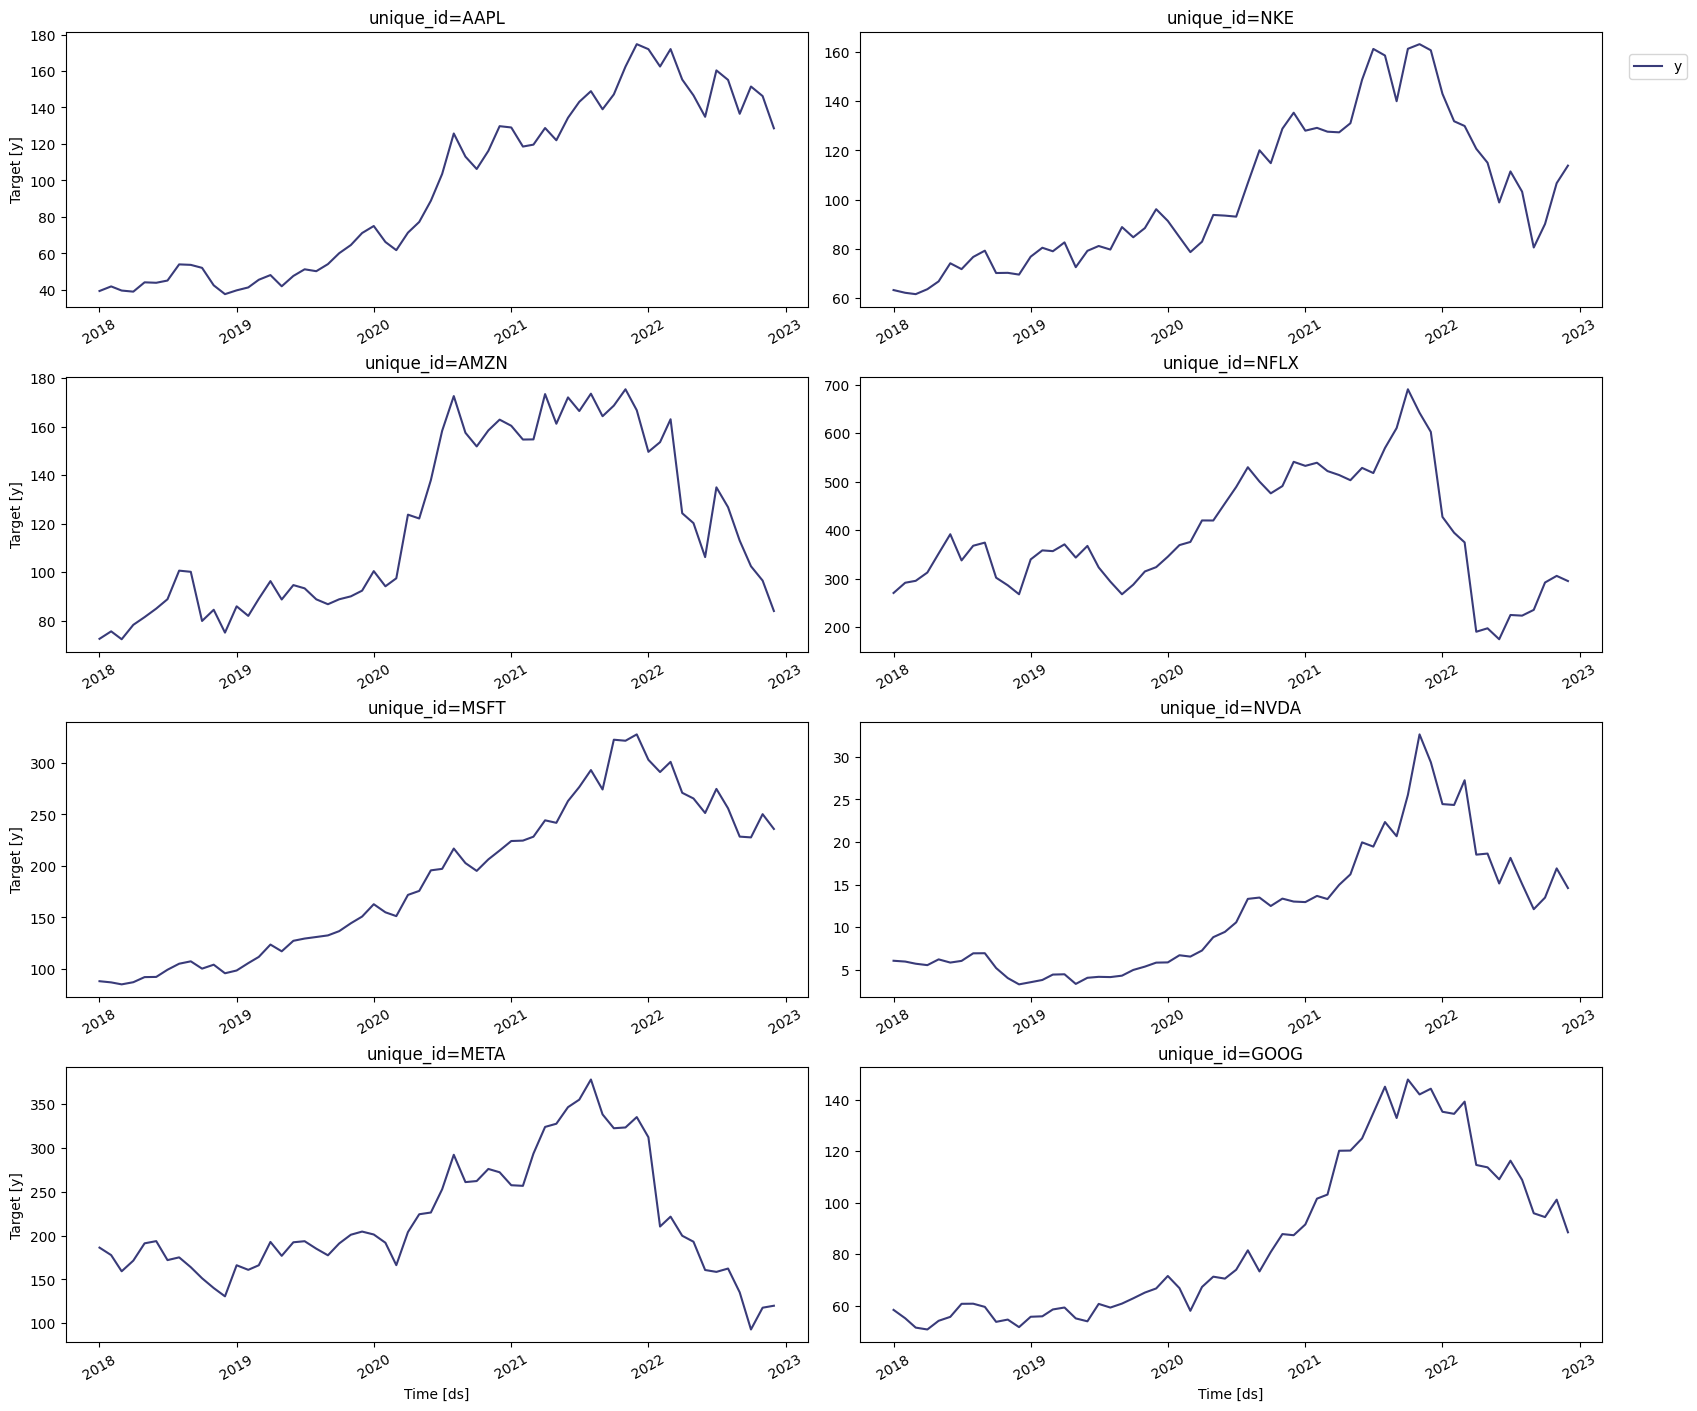

In [ ]:
StatsForecast.plot(prices)

With the prices, we can compute the logarithmic returns of the S&P 500 and the publicly traded companies. This is the variable we're interested in since it's likely to work well with the GARCH framework. The logarithmic return is given by 

$return_t = log \big( \frac{price_t}{price_{t-1}} \big)$

We'll compute the returns on the price dataframe and then we'll create a return dataframe with StatsForecast's format. To do this, we'll need `numpy`. 

In [ ]:
import numpy as np
prices['rt'] = prices['y'].div(prices.groupby('unique_id')['y'].shift(1))
prices['rt'] = np.log(prices['rt'])

returns = prices[['unique_id', 'ds', 'rt']]
returns = returns.rename(columns={'rt':'y'})
returns

,unique_id,ds,y
0,SPY,2018-01-01,NaN
1,SPY,2018-02-01,-0.037038
2,SPY,2018-03-01,-0.031790
3,SPY,2018-04-01,0.009152
4,SPY,2018-05-01,0.024018
...,...,...,...
595,NFLX,2022-08-01,-0.005976
596,NFLX,2022-09-01,0.051776
597,NFLX,2022-10-01,0.214887
598,NFLX,2022-11-01,0.045705


::: {.callout-warning}

If the order of the data is very small (say $<1e-5$), `scipy.optimize.minimize` might not terminate successfully. In this case, rescale the data and then generate the GARCH or ARCH model. 

:::


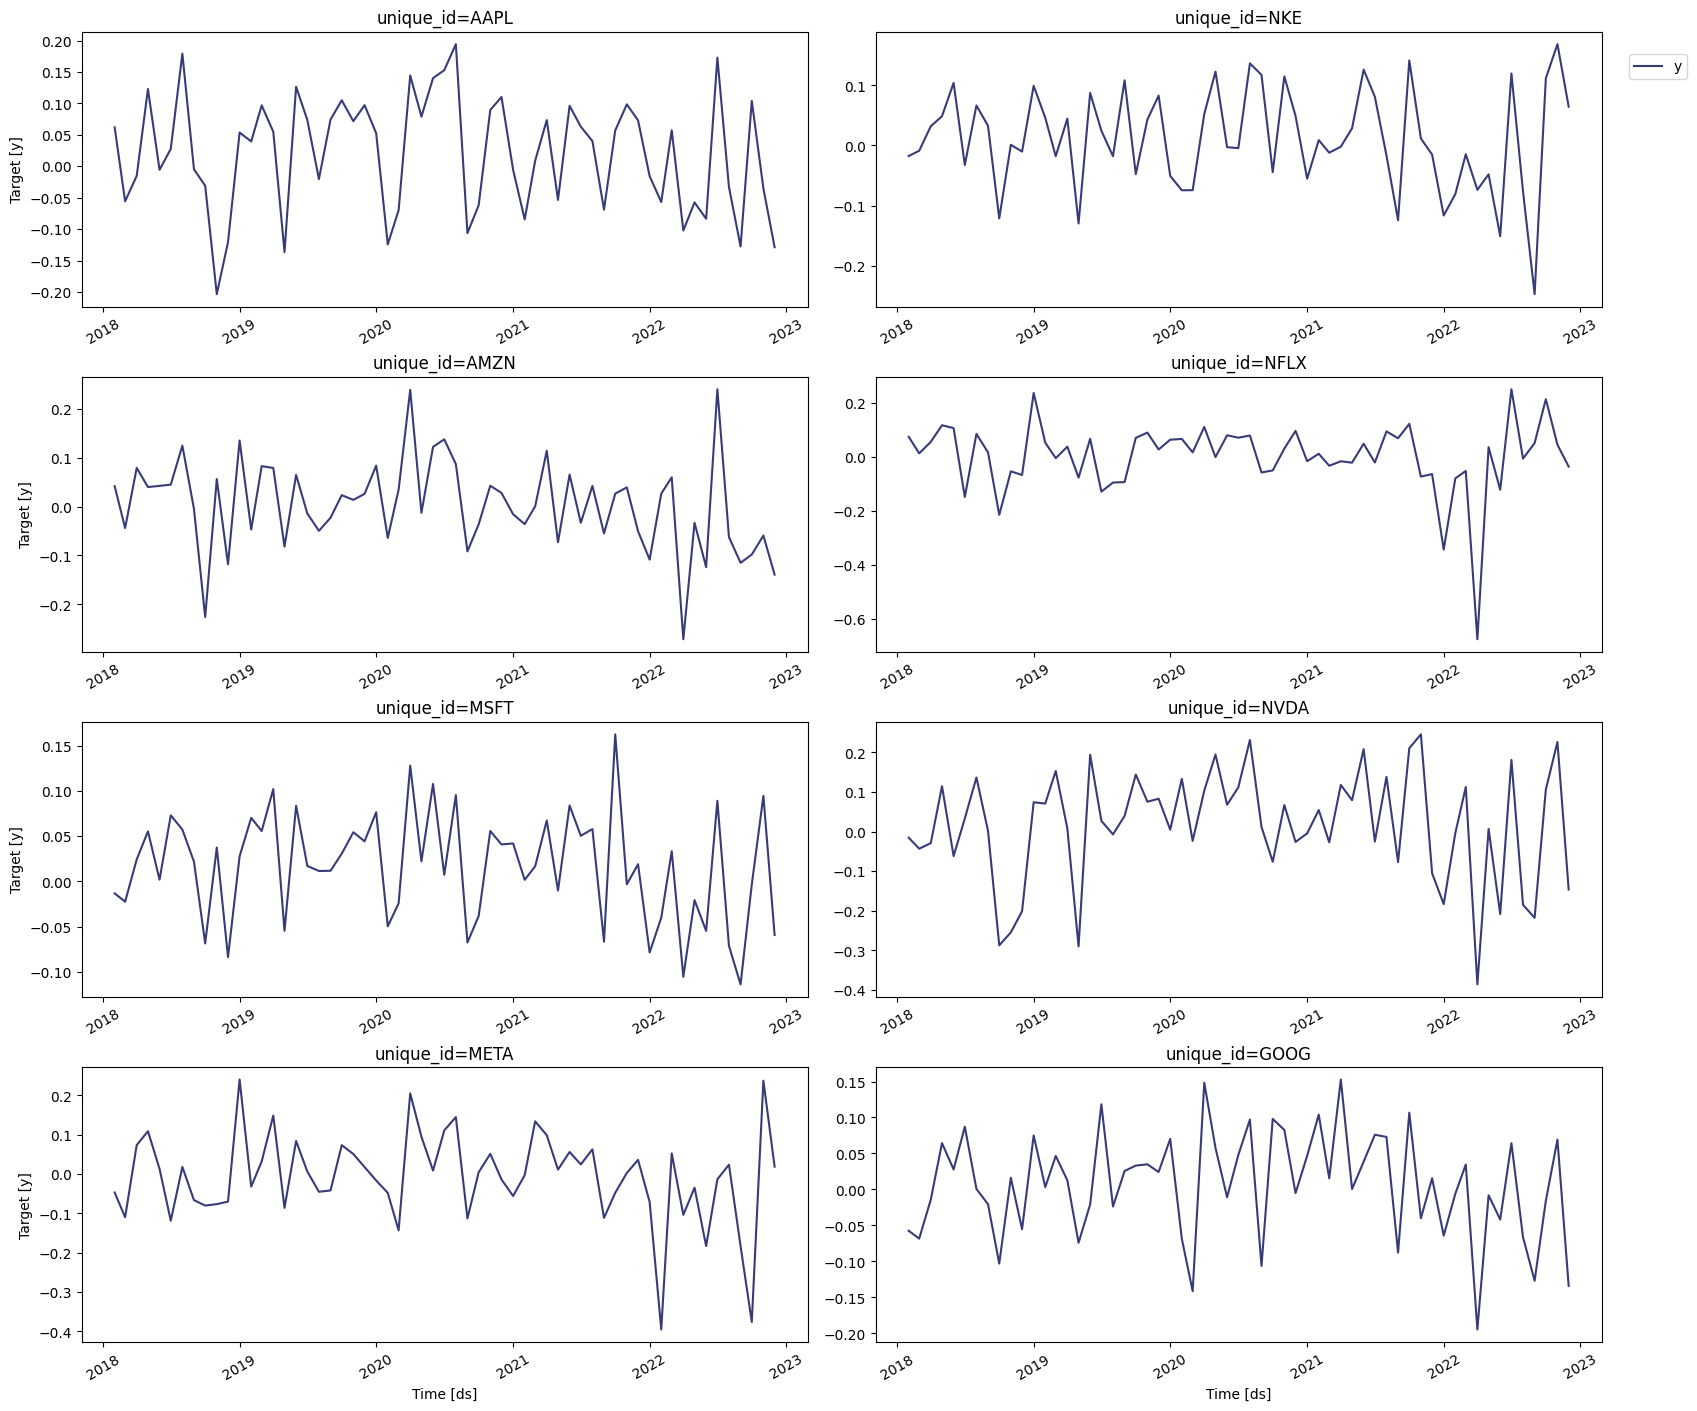

In [ ]:
StatsForecast.plot(returns)

From this plot, we can see that the returns seem suited for the GARCH framework, since large shocks _tend_ to be followed by other large shocks. This doesn't mean that after every large shock we should expect another one; merely that the probability of a large variance is greater than the probability of a small one. 

## Train models

We first need to import the [GARCH](../models/GARCH) and the [ARCH](../models/ARCH) models from `statsforecast.models`, and then we need to fit them by instantiating a new StatsForecast object. Notice that we'll be using different values of $p$ and $q$. In the next section, we'll determine which ones produce the most accurate model using cross-validation. We'll also import the [Naive](../../models#class-naive) model since we'll use it as a baseline. 

In [ ]:
from statsforecast.models import (
    GARCH,
    ARCH,
    Naive
)

models = [ARCH(1),
          ARCH(2),
          GARCH(1,1),
          GARCH(1,2),
          GARCH(2,2),
          GARCH(2,1),
          Naive()
]

To instantiate a new StatsForecast object, we need the following parameters:

- `df`: The dataframe with the training data.
- `models`: The list of models defined in the previous step.
- `freq`: A string indicating the frequency of the data. Here we'll use **MS**, which correspond to the start of the month. You can see the list of panda's available frequencies [here](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases). 
- `n_jobs`: An integer that indicates the number of jobs used in parallel processing. Use -1 to select all cores.

In [ ]:
sf = StatsForecast(
    models = models,
    freq = 'MS',
    n_jobs = -1
)

## Perform time series cross-validation

Time series cross-validation is a method for evaluating how a model would have performed in the past. It works by defining a sliding window across the historical data and predicting the period following it. Here we'll use StatsForercast's `cross-validation` method to determine the most accurate model for the S&P 500 and the companies selected. 

This method takes the following arguments: 

- `df`: The dataframe with the training data. 
- `h` (int): represents the h steps into the future that will be forecasted.
- `step_size` (int): step size between each window, meaning how often do you want to run the forecasting process.
- `n_windows` (int): number of windows used for cross-validation, meaning the number of forecasting processes in the past you want to evaluate.

For this particular example, we'll use 4 windows of 3 months, or all the quarters in a year. 

In [ ]:
cv_df = sf.cross_validation(
    df = returns,
    h = 3,
    step_size = 3,
    n_windows = 4
  )

The `cv_df` object ia a dataframe with the following columns: 

- `unique_id`: series identifier.
- `ds`: datestamp or temporal index
- `cutoff`: the last datestamp or temporal index for the `n_windows`.
- `y`: true value
- `"model"`: columns with the model’s name and fitted value.

In [ ]:
cv_df.rename(columns = {'y' : 'actual'}, inplace = True)
cv_df.head()

,unique_id,ds,cutoff,actual,ARCH(1),ARCH(2),"GARCH(1,1)","GARCH(1,2)","GARCH(2,2)","GARCH(2,1)",Naive
0,AAPL,2022-01-01,2021-12-01,-0.015837,0.142421,0.144016,0.142954,0.141682,0.141682,0.144015,0.073061
1,AAPL,2022-02-01,2021-12-01,-0.056856,-0.056893,-0.057158,-0.056388,-0.058786,-0.058785,-0.057158,0.073061
2,AAPL,2022-03-01,2021-12-01,0.057156,-0.045901,-0.046479,-0.047513,-0.045711,-0.045711,-0.046478,0.073061
3,AAPL,2022-04-01,2022-03-01,-0.102178,0.138650,0.140222,0.228138,0.136118,0.136132,0.140211,0.057156
4,AAPL,2022-05-01,2022-03-01,-0.057505,-0.056007,-0.056268,-0.087833,-0.057078,-0.057085,-0.056265,0.057156


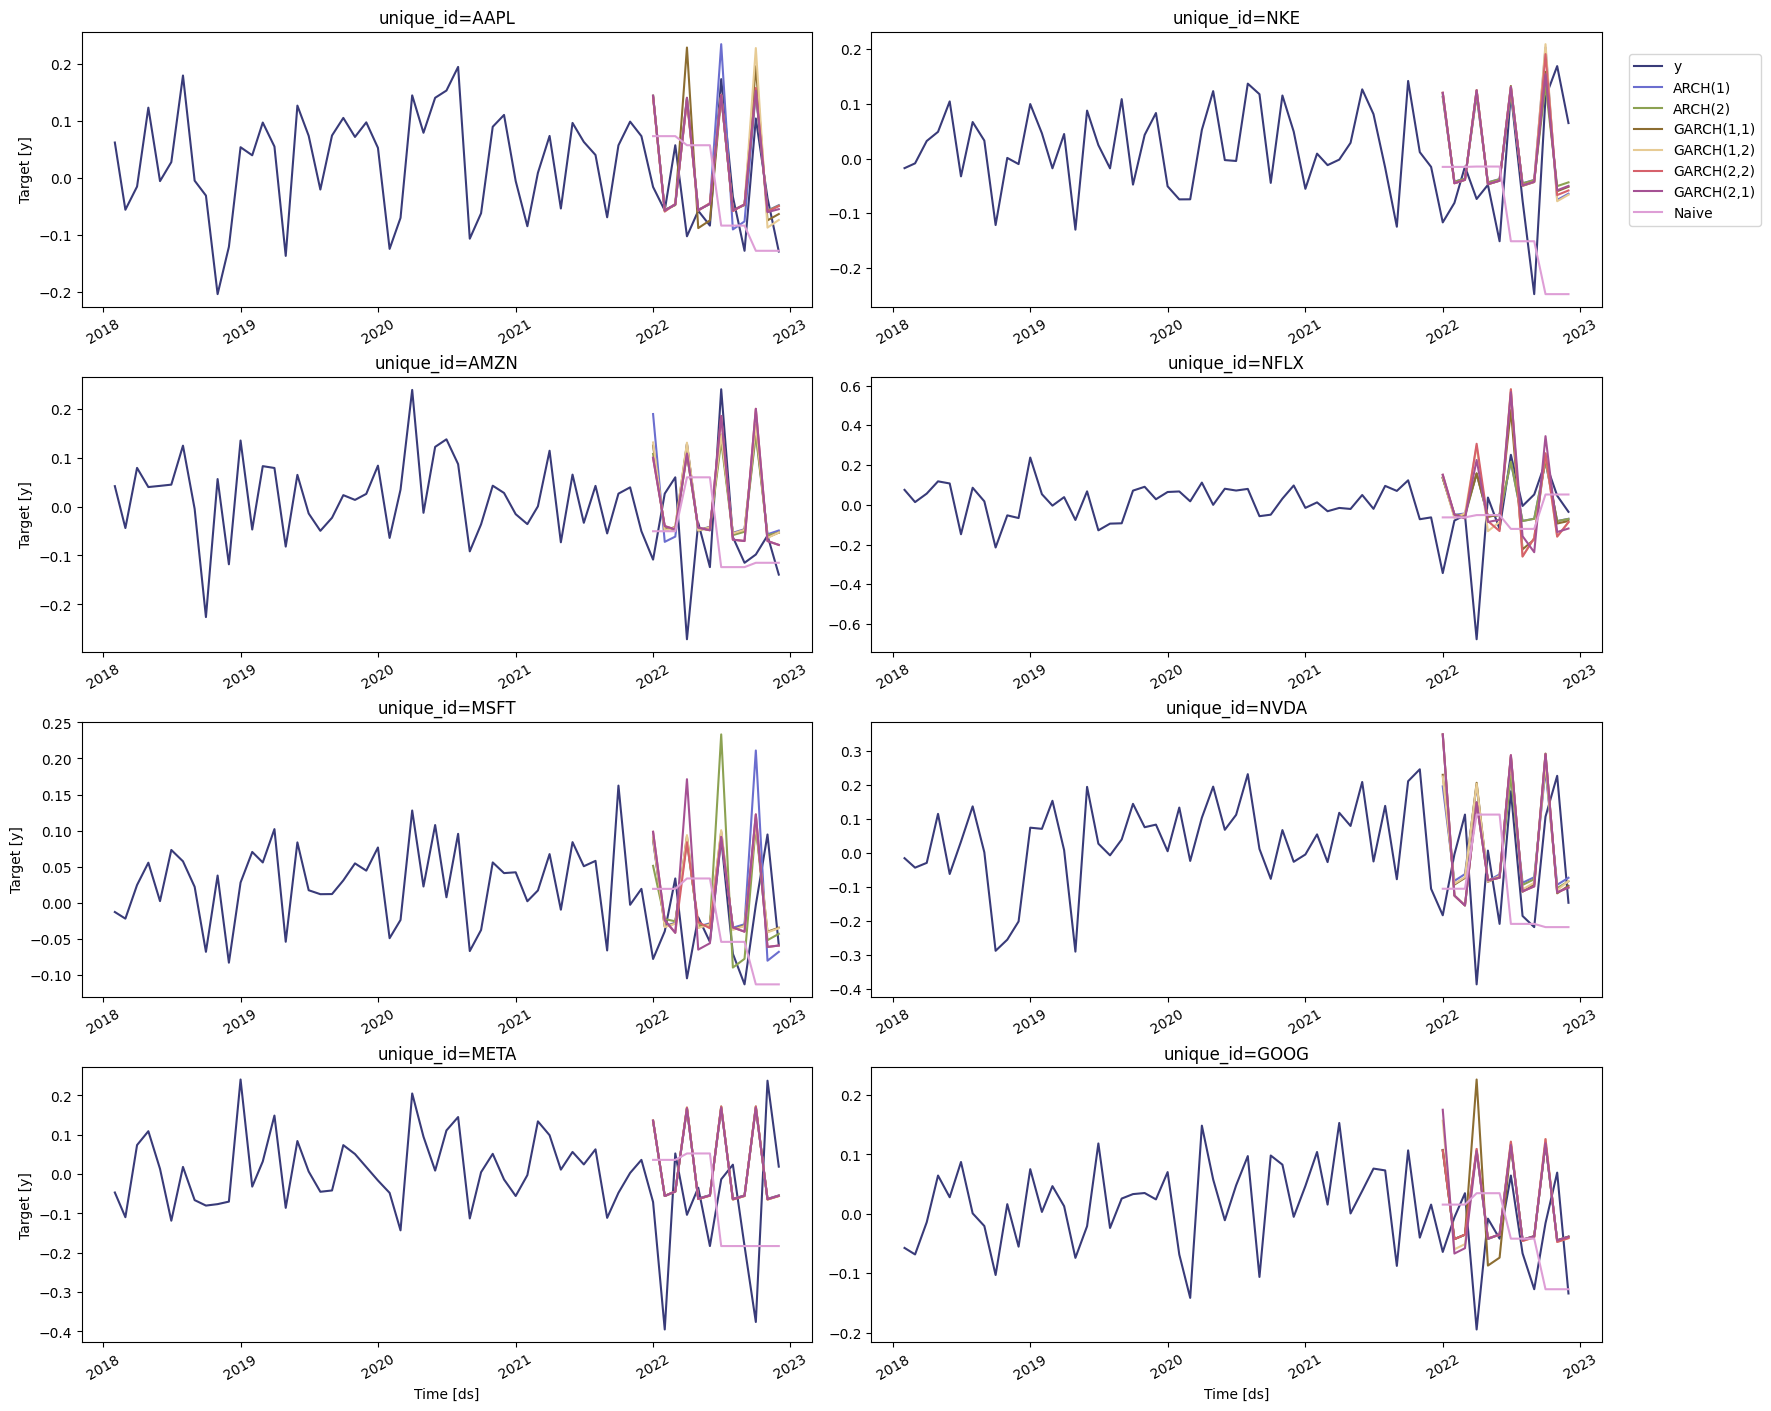

In [ ]:
StatsForecast.plot(returns, cv_df.drop(['cutoff', 'actual'], axis=1))

A tutorial on cross-validation can be found [here](./CrossValidation)

## Evaluate results 

To compute the accuracy of the forecasts, we’ll use the mean average error (mae), which is the sum of the absolute errors divided by the number of forecasts.

In [ ]:
from utilsforecast.losses import mae

The MAE needs to be computed for every window and then it needs to be averaged across all of them. To do this, we'll create the following function. 

In [ ]:
models = cv_df.columns.drop(['unique_id', 'ds', 'cutoff', 'actual'])

In [ ]:
mae_cv = mae(cv_df, models=models, target_col='actual').set_index('unique_id')
mae_cv

,ARCH(1),ARCH(2),"GARCH(1,1)","GARCH(1,2)","GARCH(2,2)","GARCH(2,1)",Naive
unique_id,,,,,,,
AAPL,0.071773,0.068927,0.080182,0.075321,0.069187,0.068817,0.110426
AMZN,0.127390,0.113613,0.118859,0.119930,0.109910,0.109910,0.115189
GOOG,0.093849,0.093753,0.109662,0.101583,0.094648,0.103389,0.083233
META,0.198334,0.198893,0.199615,0.199711,0.199712,0.198892,0.185346
MSFT,0.082373,0.075055,0.072241,0.072765,0.073006,0.082066,0.086951
NFLX,0.159386,0.159528,0.199623,0.232477,0.230075,0.230770,0.167421
NKE,0.108337,0.098918,0.103366,0.110278,0.107179,0.102708,0.160404
NVDA,0.189461,0.207871,0.198999,0.196170,0.211932,0.211940,0.215289
SPY,0.058511,0.058583,0.058701,0.062492,0.057053,0.068192,0.089012


In [ ]:
mae_cv.idxmin(axis=1)

unique_id
AAPL    GARCH(2,1)
AMZN    GARCH(2,2)
GOOG         Naive
META         Naive
MSFT    GARCH(1,1)
NFLX       ARCH(1)
NKE        ARCH(2)
NVDA       ARCH(1)
SPY     GARCH(2,2)
TSLA    GARCH(1,1)
dtype: object

Hence, the most accurate model to describe the logarithmic returns of Apple's stock is an GARCH(2, 1), for Amazon's stock is a GARCH(2,2), and so on. 

## Forecast volatility 

We can now generate a forecast for the next quarter. To do this, we'll use the `forecast` method, which requieres the following arguments:

- `h`: (int) The forecasting horizon.
- `level`: (list[float]) The confidence levels of the prediction intervals
- `fitted` : (bool = False) Returns insample predictions.

In [ ]:
levels = [80, 95] # confidence levels for the prediction intervals

forecasts = sf.forecast(df=returns, h=3, level=levels)
forecasts.head()

,unique_id,ds,ARCH(1),ARCH(1)-lo-95,ARCH(1)-lo-80,ARCH(1)-hi-80,ARCH(1)-hi-95,ARCH(2),ARCH(2)-lo-95,ARCH(2)-lo-80,...,"GARCH(2,1)","GARCH(2,1)-lo-95","GARCH(2,1)-lo-80","GARCH(2,1)-hi-80","GARCH(2,1)-hi-95",Naive,Naive-lo-80,Naive-lo-95,Naive-hi-80,Naive-hi-95
0,AAPL,2023-01-01,0.150457,0.133641,0.139462,0.161453,0.167273,0.150158,0.133409,0.139206,...,0.147602,0.131418,0.137020,0.158184,0.163786,-0.128762,-0.284462,-0.366885,0.026939,0.109362
1,AAPL,2023-02-01,-0.056943,-0.073924,-0.068046,-0.045839,-0.039961,-0.057207,-0.074346,-0.068414,...,-0.059512,-0.078060,-0.071640,-0.047384,-0.040964,-0.128762,-0.348956,-0.465520,0.091433,0.207997
2,AAPL,2023-03-01,-0.048391,-0.064843,-0.059148,-0.037633,-0.031939,-0.049282,-0.066345,-0.060439,...,-0.054539,-0.075438,-0.068204,-0.040875,-0.033641,-0.128762,-0.398443,-0.541204,0.140920,0.283681
3,AMZN,2023-01-01,0.152147,0.134952,0.140904,0.163391,0.169343,0.148658,0.132242,0.137924,...,0.148599,0.132196,0.137873,0.159324,0.165001,-0.139141,-0.315716,-0.409190,0.037435,0.130909
4,AMZN,2023-02-01,-0.057301,-0.074497,-0.068545,-0.046058,-0.040106,-0.061187,-0.080794,-0.074007,...,-0.069303,-0.094457,-0.085750,-0.052856,-0.044150,-0.139141,-0.388856,-0.521048,0.110575,0.242767


With the results of the previous section, we can choose the best model for the S&P 500 and the companies selected. Some of the plots are shown below. Notice that we're using somo additional arguments in the `plot` method: 

- `level`: (list[int]) The confidence levels for the prediction intervals (this was already defined). 
- `unique_ids`: (list[str, int or category]) The ids to plot. 
- `models`: (list(str)). The model to plot. In this case, is the model selected by cross-validation.

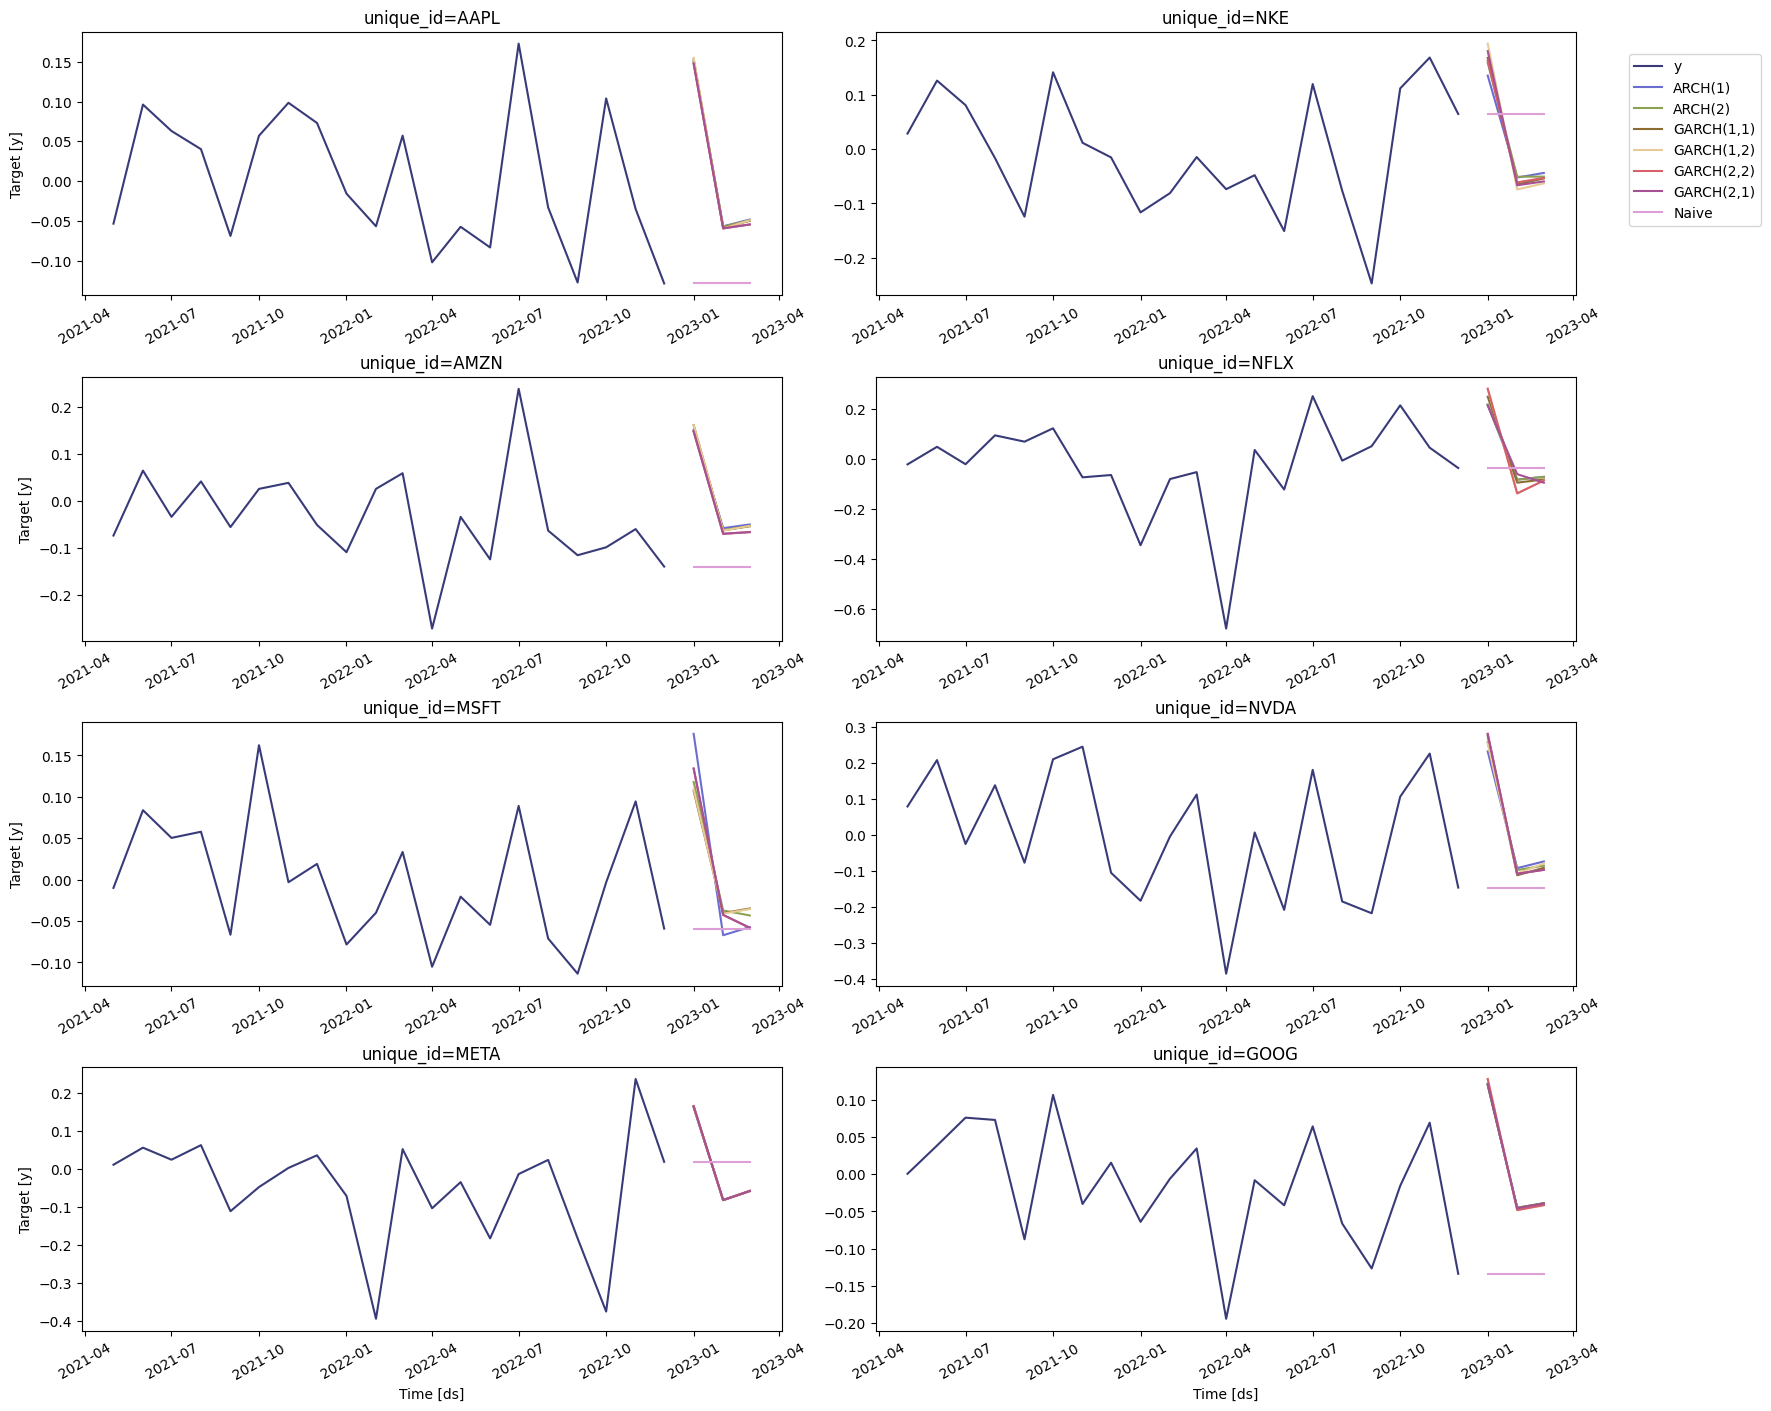

In [ ]:
StatsForecast.plot(returns, forecasts, max_insample_length=20)

## References 

- [Engle, R. F. (1982). Autoregressive conditional heteroscedasticity with estimates of the variance of United Kingdom inflation. Econometrica: Journal of the econometric society, 987-1007.](http://www.econ.uiuc.edu/~econ508/Papers/engle82.pdf) 

- [Bollerslev, T. (1986). Generalized autoregressive conditional heteroskedasticity. Journal of econometrics, 31(3), 307-327.](https://citeseerx.ist.psu.edu/document?repid=rep1&type=pdf&doi=7da8bfa5295375c1141d797e80065a599153c19d)

- [Hamilton, J. D. (1994). Time series analysis. Princeton university press.](https://press.princeton.edu/books/hardcover/9780691042893/time-series-analysis)

- [Tsay, R. S. (2005). Analysis of financial time series. John wiley & sons.](https://www.wiley.com/en-us/Analysis+of+Financial+Time+Series%2C+3rd+Edition-p-9780470414354)